# Convolution Embedding

<img src="https://github.com/SeyaSchmassmann/wods/blob/main/CvT-SimplifiedEmbedding.drawio.png?raw=1" alt="CvT-Modell mit Convolutional Embedding" title="CvT-Modell mit Convolutional Embedding" height="400" />

Dimensions sind ohne Batch-Size.

## Input-Dimensions

**Dimensions:** $H_0 = 64px, \quad W_0 = 64px, \quad C_0 = 3$ \
**Output-Shape:** `(3, 64, 64)`

## Conv2d

Berechnung Output-Dimensions:

$ \text{kernel size}\ k = 7, \quad \text{stride}\ s = 4, \quad \text{padding}\ p = 3 $ \
$ H_i = \frac{H_{i-1} + 2p - k}{s}\ + 1, \quad W_i = \frac{W_{i-1} + 2p - k}{s}\ + 1 $

**Output-Dimensions:** $H_1 = 16px, \quad W_1 = 16px, \quad C_1 = 64$ \
**Output-Shape:** `(64, 16, 16)`

## Flatten

**Output-Dimensions:** $H_1 W_1 \times C_1 = 16*16 \times 64$ \
**Output-Shape:** `(256, 64)`

## Multi-Head Attention

Berechnung der Query-, Key- und Value-Matrizen:

$X \in \mathbb{R}^{H_1 W_1 \times C_1}$ \
$d_k$ ist die Dimension der Value-, Query- und Key-Vektoren \
$W^Q, W^K, W^V \in \mathbb{R}^{C_1 \times d_k}$ \
$Q = XW^Q, \quad K = XW^K, \quad V = XW^V$

$d_k = 64$ \
$Q, K, V \in \mathbb{R}^{256 \times 64}$

**Output-Dimensions:** $256 \times 64$ \
**Output-Shape:** `(256, 64)`

## MLP

Expansion factor: $e = 4$

1. **Step:** Linear ➔ GELU ➔ Dropout
   
   **Output-Dimensions:** $256 \times 64 \times 4 = 256 \times 256$ \
   **Output-Shape:** `(256, 256)`

2. **Step:** Linear ➔ Dropout

    **Output-Dimensions:** $256 \times 256 \times 64 = 256 \times 64$ \
    **Output-Shape:** `(256, 64)`


# Imports

In [2]:
%pip install pytorch-lightning
%pip install lightning
%pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 18.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 68.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 15.7 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import lightning as L
from einops import rearrange
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torch
import torch.nn.functional as F
from torchmetrics.classification import Accuracy
from pathlib import Path
import wandb

In [4]:
def extract_data(dir_datazip, dir_data):
    if os.path.exists(dir_data):
        print("Data already extracted.")
        return

    if not os.path.exists(dir_datazip):
        raise FileNotFoundError("Data not found")

    print("Extracting data...")
    shutil.unpack_archive(dir_datazip, dir_data)


def process_validation_set(val_images_dir, val_annotations_file, val_processed_dir):
    if not os.path.exists(val_processed_dir):
        print("Processing validation set...")
        os.makedirs(val_processed_dir, exist_ok=True)

        with open(val_annotations_file, "r") as f:
            lines = f.readlines()
        img_to_class = {line.split("\t")[0]: line.split("\t")[1] for line in lines}

        for img_name, class_name in img_to_class.items():
            class_folder = os.path.join(val_processed_dir, class_name)
            os.makedirs(class_folder, exist_ok=True)
            src = os.path.join(val_images_dir, img_name)
            dst = os.path.join(class_folder, img_name)
            if os.path.exists(src):
                shutil.copy(src, dst)


dir_datazip = Path("/datasets/tiny-imagenet-200/tiny-imagenet-200.zip") # Path("data/tiny-imagenet-200.zip")
dir_data = Path("data/tiny-imagenet-200")
extract_data(dir_datazip, Path("data"))

dir_data_train = os.path.join(dir_data, "train")
dir_data_val = os.path.join(dir_data, "val")

dir_val_images = os.path.join(dir_data_val, "images")
dir_val_annotations = os.path.join(dir_data_val, "val_annotations.txt")

dir_data_val_processed = os.path.join(dir_data, "val_processed")
process_validation_set(dir_val_images, dir_val_annotations, dir_data_val_processed)

Data already extracted.


# Modell

In [5]:
class EmbeddingBlock(nn.Module):
    def __init__(self,
                 in_channels=3,
                 embed_dim=64,
                 patch_size=7,
                 stride=4,
                 padding=3,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=stride,
            padding=padding
        )
        self.norm = norm_layer(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.norm(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self,
                 embed_dim=64,
                 num_heads=1,
                 mlp_ratio=4.0,
                 drop=0.1,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop, batch_first=True)

        self.norm2 = norm_layer(embed_dim)
        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

## Testing

In [6]:
input = torch.randn(2, 3, 64, 64)
excepted_output_shape = (2, 256, 64)

embedding_block = EmbeddingBlock()
transformer_block = TransformerBlock()

output = embedding_block(input)
output = transformer_block(output)

assert output.shape == excepted_output_shape, f"Expected shape {excepted_output_shape}, but got {output.shape}"
print("Output shape is as expected:", output.shape)

Output shape is as expected: torch.Size([2, 256, 64])


# Dataset

In [7]:
def get_tiny_imagenet_loaders(dir_data_train,
                              dir_data_val_processed,
                              batch_size=32,
                              num_workers=4,
                              img_size=64,
                              val_split=0.2,
                              seed=42):

    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(img_size, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4802, 0.4481, 0.3975],
                             std=[0.2302, 0.2265, 0.2262]),
    ])

    val_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4802, 0.4481, 0.3975],
                             std=[0.2302, 0.2265, 0.2262]),
    ])

    train_dataset = datasets.ImageFolder(dir_data_train, transform=train_transforms)
    full_val_dataset = datasets.ImageFolder(dir_data_val_processed, transform=val_transforms)

    val_size = int(val_split * len(full_val_dataset))
    test_size = len(full_val_dataset) - val_size
    generator = torch.Generator().manual_seed(seed)
    val_dataset, test_dataset = random_split(full_val_dataset, [val_size, test_size], generator=generator)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [8]:
train_loader, val_loader, test_loader = get_tiny_imagenet_loaders(
    dir_data_train,
    dir_data_val_processed,
    batch_size=64,
    num_workers=8
)

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Data loaders are working correctly.


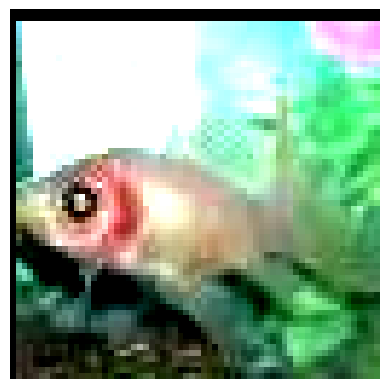

In [9]:
assert len(train_loader.dataset) == 100000 , "Expected 100000 training samples"
assert len(val_loader.dataset) == 2000, "Expected 2000 validation samples"
assert len(test_loader.dataset) == 8000, "Expected 8000 test samples"

assert train_loader.batch_size == 64, "Expected batch size of 64"
assert val_loader.batch_size == 64, "Expected batch size of 64"
assert test_loader.batch_size == 64, "Expected batch size of 64"

assert (next(iter(train_loader))[0].shape == (64, 3, 64, 64)), "Expected input shape of (64, 3, 64, 64)"
assert (next(iter(val_loader))[0].shape == (64, 3, 64, 64)), "Expected input shape of (64, 3, 64, 64)"
assert (next(iter(test_loader))[0].shape == (64, 3, 64, 64)), "Expected input shape of (64, 3, 64, 64)"

print("Data loaders are working correctly.")

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

image, label = train_loader.dataset[0]
imshow(image)

# Model

In [10]:
class CvTSimplifiedEmbedding(nn.Module):
    def __init__(self,
                 in_channels=3,
                 num_classes=200,
                 embed_dim=64,
                 depth=2):
        super().__init__()

        self.num_classes = num_classes

        self.embedding = EmbeddingBlock(
            in_channels=in_channels,
            embed_dim=embed_dim,
            stride=4,
            padding=3,
            norm_layer=nn.LayerNorm
        )

        self.transformer_blocks = nn.Sequential(*[
            TransformerBlock() for _ in range(depth)
        ])

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(1),
            nn.Linear(embed_dim, num_classes)
        )


    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_blocks(x)
        x = x.permute(0, 2, 1)
        x = self.head(x)
        return x

## Testing

In [11]:
model = CvTSimplifiedEmbedding()
dummy_input = torch.randn(8, 3, 64, 64)
output = model(dummy_input)

assert output.shape == (8, 200), f"Expected output shape (8, 200), but got {output.shape}"
print("Model output shape is as expected:", output.shape)

Model output shape is as expected: torch.Size([8, 200])


# Training

In [16]:
class LitModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_acc = Accuracy(task="multiclass", num_classes=model.num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=model.num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=model.num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = logits.argmax(dim=1)
        self.train_acc(preds, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = logits.argmax(dim=1)
        self.val_acc(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = logits.argmax(dim=1)
        self.test_acc(preds, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [23]:
model = LitModel(CvTSimplifiedEmbedding())

wandb.login(key="")
wandb_logger = WandbLogger(entity="wods", project="wods")
wandb_logger.experiment.config["batch_size"] = 64

trainer = pl.Trainer(max_epochs=50,
                     accelerator="auto",
                     devices="auto",
                     logger=wandb_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)
wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f69e9296990>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f697c337850, raw_cell="model = LitModel(CvTSimplifiedEmbedding())

wandb..." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Seya.Schmassmann/Code/studium/wods/wods/CvT-SimplifiedEmbedding.ipynb#X26sZmlsZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seya-schmassmann-fhnw (wods). Use `wandb login --relogin` to force relogin


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | CvTSimplifiedEmbedding | 122 K  | train
1 | criterion | CrossEntropyLoss       | 0      | train
2 | train_acc | MulticlassAccuracy     | 0      | train
3 | val_acc   | MulticlassAccuracy     | 0      | train
4 | test_acc  | MulticlassAccuracy     | 0      | train
-------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.490     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.34299999475479126
        test_loss            2.923672914505005
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb: ERROR Control-C detected -- Run data was not synced


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f69e9296990>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f69b2a93650, execution_count=23 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f697c337850, raw_cell="model = LitModel(CvTSimplifiedEmbedding())

wandb..." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Seya.Schmassmann/Code/studium/wods/wods/CvT-SimplifiedEmbedding.ipynb#X26sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given